In [2]:
import os
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
from io import StringIO
import re
from IPython.display import display, Latex

In [3]:
def get_results(res_path):
    # group file names by configuration
    results_by_specs = defaultdict(list)
    for fname in os.listdir(res_path):
        if not fname.endswith('.txt'):
            continue

        try:
            spec, day, hour = fname[:-len('.txt')].split('-')
            _, model, features, trend, most = spec.split('_')
        except:
            print('skipping', fname)
            continue

        results_by_specs[(model, features, trend, most)].append(fname)
    
    # for each config, find and parse most recent result file
    df_rows, df_cols = [], None
    for spec, files in results_by_specs.items():
        res_file, res_lines, found = list(sorted(files))[-1], [], False
        with open(os.path.join(res_path, res_file)) as f:
            for i, row in enumerate(f):
                rr = row.strip()
                
                if found and not rr.startswith('**'):
                    res_lines.append(rr)
                elif found and rr.startswith('**'):
                    break
                elif not found and rr.startswith('**raw scores'):
                    found = True
            
        assert res_lines

        csv_text = re.sub('[ \t]+', ',', '\n'.join(res_lines))
        metrics_df = pd.read_csv(StringIO(csv_text))
        for col in metrics_df:
            for val in metrics_df[col]:
                df_rows.append(list(spec) + [col, val])

        if df_cols is None:
            df_cols = [
                'estimator', 'features', 'trend', 'most', 'metric', 'value'
            ]

    results = pd.DataFrame(df_rows, columns=df_cols)
    return results


res = get_results('dev/results')
res.head(5)

,estimator,features,trend,most,metric,value
0,GradientBoostingRegressor,f1,notrend,most,explained_variance_score,0.662766
1,GradientBoostingRegressor,f1,notrend,most,explained_variance_score,0.742311
2,GradientBoostingRegressor,f1,notrend,most,explained_variance_score,0.778146
3,GradientBoostingRegressor,f1,notrend,most,explained_variance_score,0.754339
4,GradientBoostingRegressor,f1,notrend,most,explained_variance_score,0.784047


In [66]:
def paint_boxplot(bplot, all_color=None, **kwargs):
    # use all_color to paing all elements of the same color
    # or specify color for each element in kwargs
    # kwargs take precedence over all_color
    #
    # NB available elements are
    # boxes, medians, whiskers, caps, fliers, means

    for key in bplot:
        color = kwargs.get(key, all_color)
        if color:
            for element in bplot[key]:
                element.set_color(color)


def make_base_plot(res, estimator, most, metric, save_path=None, plot_all=False):
    most = 'most' if most else 'nomost'
    plot_data, found = [], False
    fig, ax = plt.subplots()

    for features in range(1, 6):
        for tidx, trend in enumerate(['trend', 'notrend']):
            vals = res[
                (res.estimator == estimator) &
                (res.most == most) &
                (res.features == 'f%d' % features) &
                (res.trend == trend) & 
                (res.metric == metric)
            ]['value'].values
            
            if vals.size == 0:
                plot_data.append([])
                continue

            if plot_all:
                plt.scatter([3 * (features - 1) + tidx] * len(vals), vals,
                            color='C%d' % tidx, s=7, zorder=10, marker='.')

            plot_data.append(vals)
            found = True

    assert found, 'no results'

    # trend
    bp1 = ax.boxplot(plot_data[::2], positions=range(0, 15, 3),
                     showmeans=True, patch_artist=False, zorder=5,
                     sym='C0.', showfliers=not plot_all)
    paint_boxplot(bp1, 'C0')

    # no trend
    bp2 = ax.boxplot(plot_data[1::2], positions=range(1, 15, 3),
                     showmeans=True, patch_artist=False, zorder=5,
                     sym='C1.', showfliers=not plot_all)
    paint_boxplot(bp2, 'C1')
    
    # most baseline
    #most_mean, most_std = 0.332056, 0.017246
    #bot, top = most_mean - 2 * most_std, most_mean + 2 * most_std
    #plt.plot([-1, 14], [most_mean, most_mean], c='C4')
    #ax.fill_between([-1, 14], [bot, bot], [top, top], alpha=0.25, color='C4')
    
    ax.margins(y=0.05)
    ax.set_xlim(-1, 14)
    ax.set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
    ax.set_xticklabels(['F1', 'F2', 'F3', 'F4', 'F5'])
    
    fig.tight_layout()
    
    if save_path is not None:
        fig.savefig(os.path.join(
            save_path, 'result_%s_%s_%s.png' % (estimator, most, metric)
        ))
    
    ax.set_title(
        estimator +
        ' - ' + '%smost' % ('' if most else 'no ') +
        ' - ' + metric.replace('_', ' ')
    )

    return fig, ax

## generation of charts

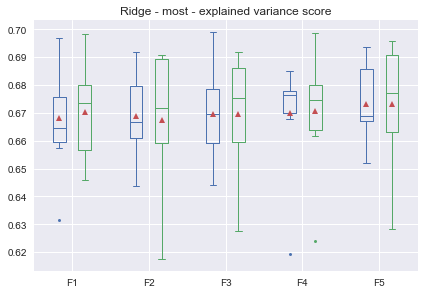

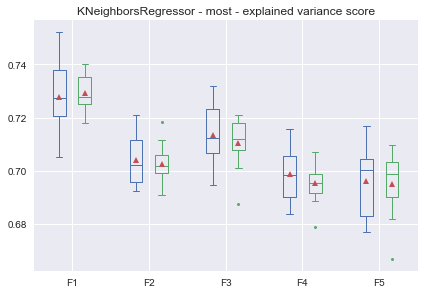

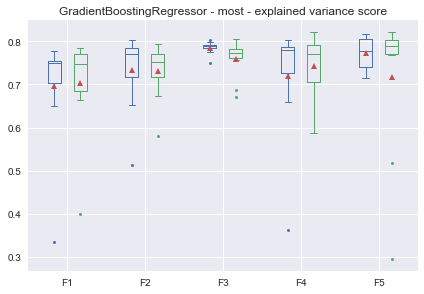

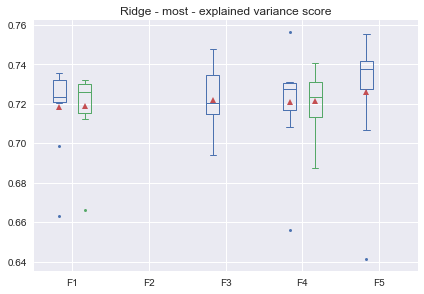

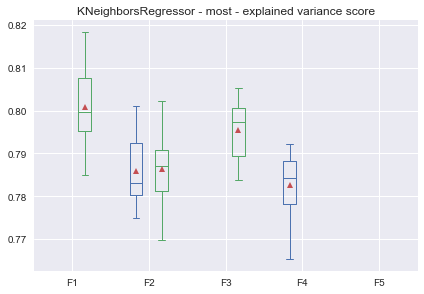

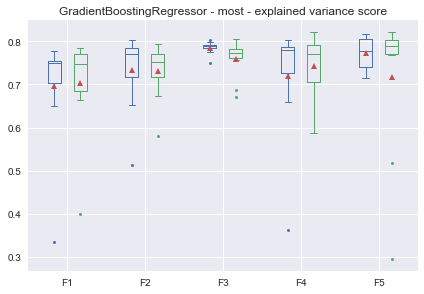

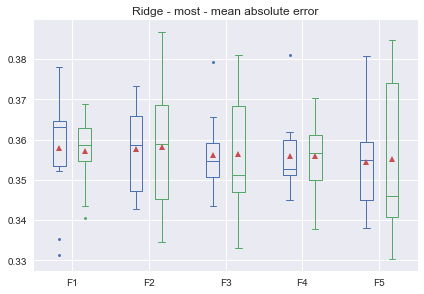

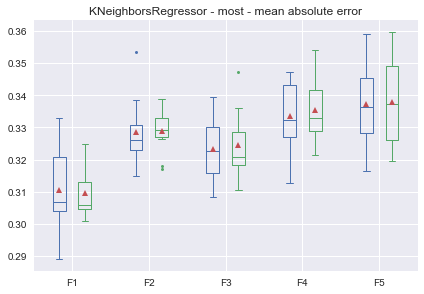

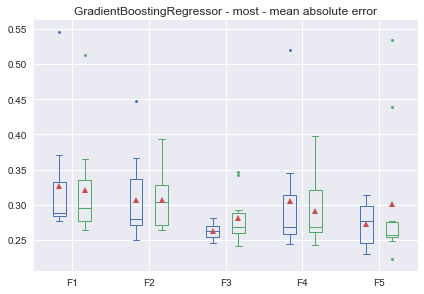

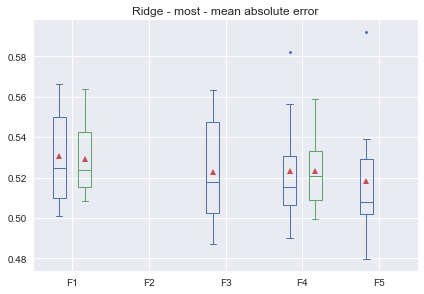

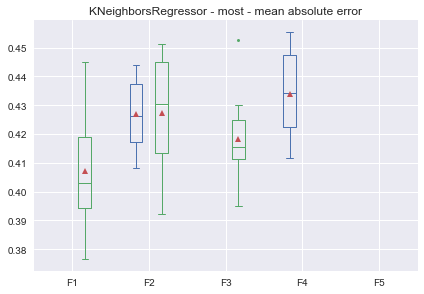

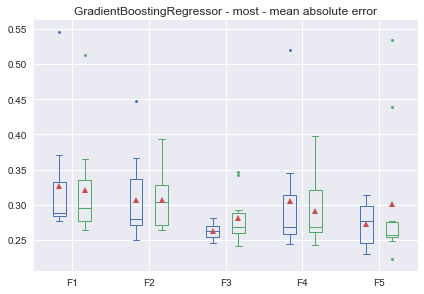

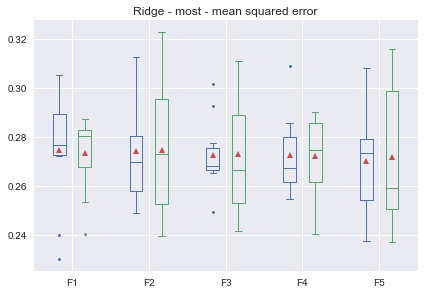

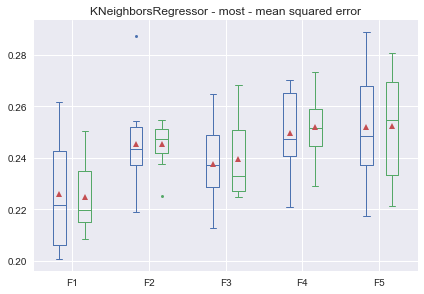

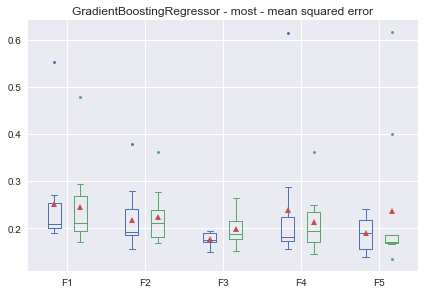

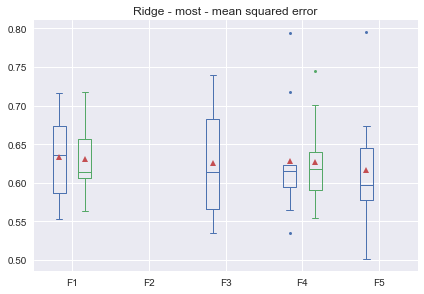

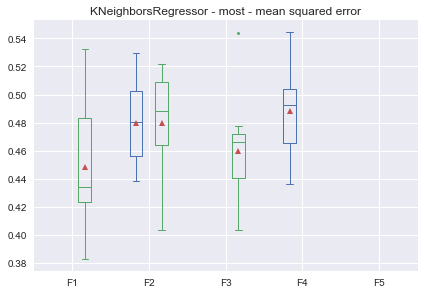

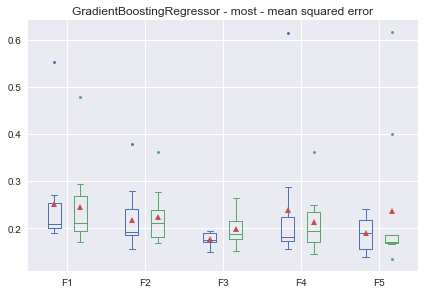

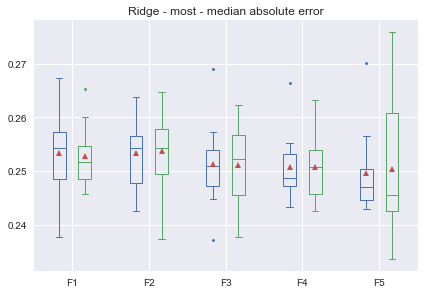

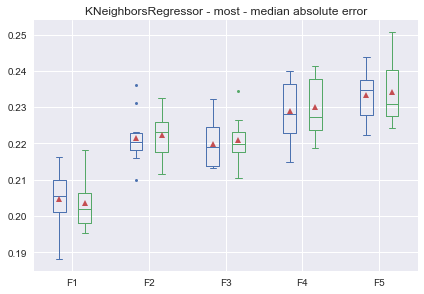

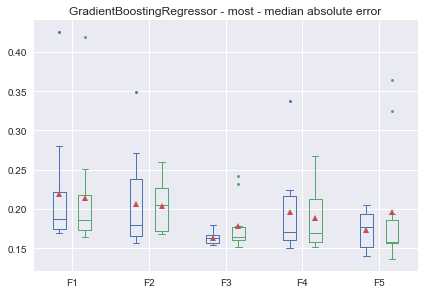

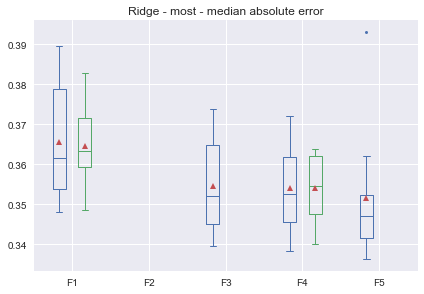

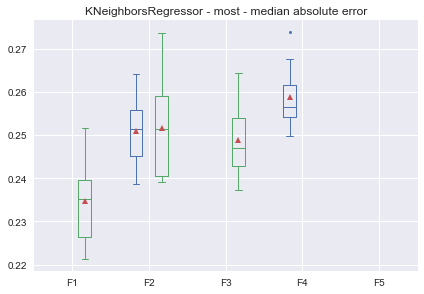

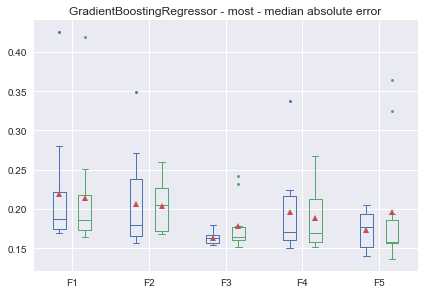

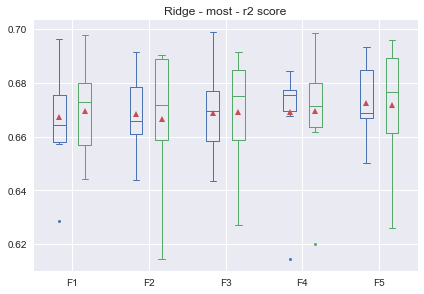

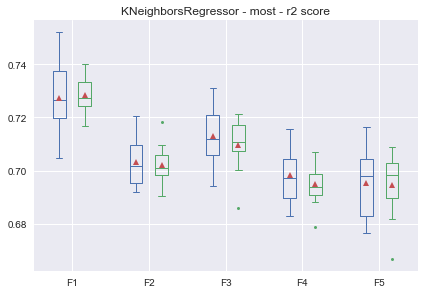

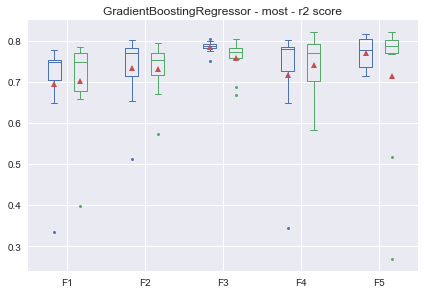

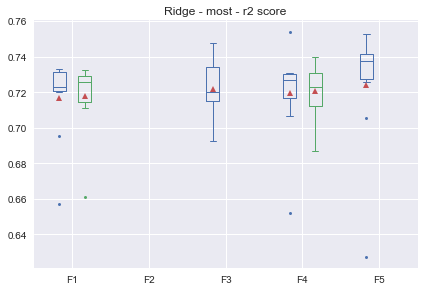

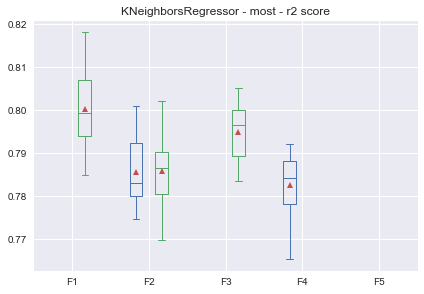

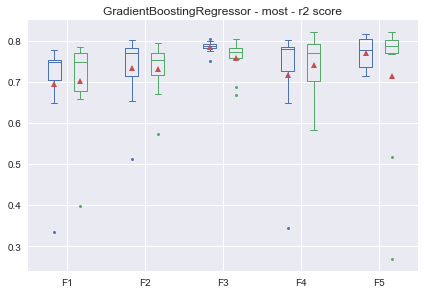

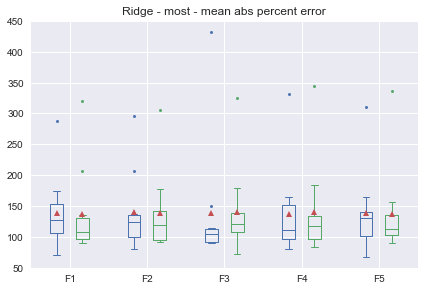

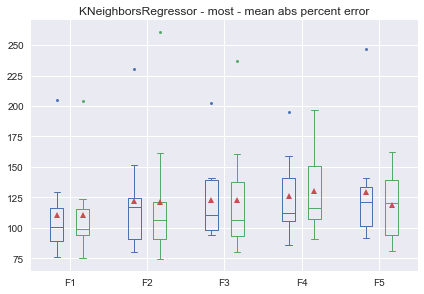

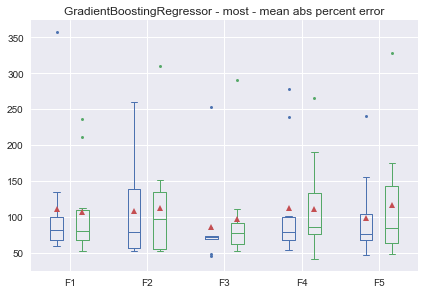

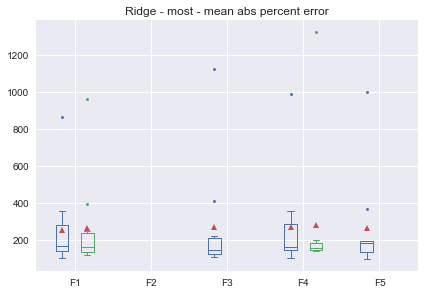

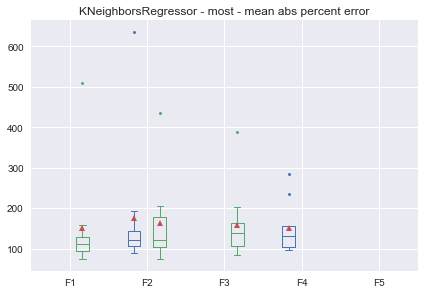

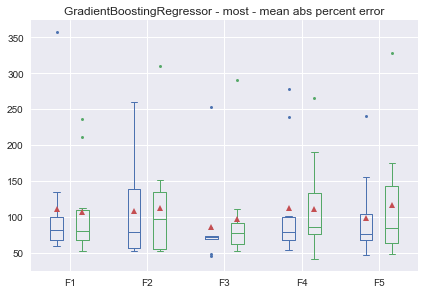

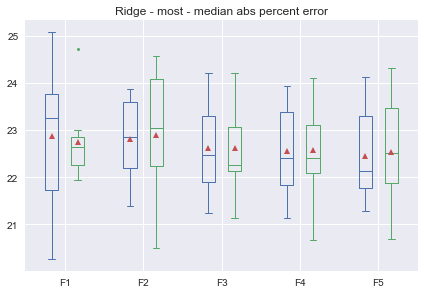

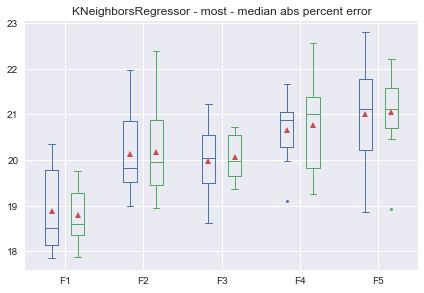

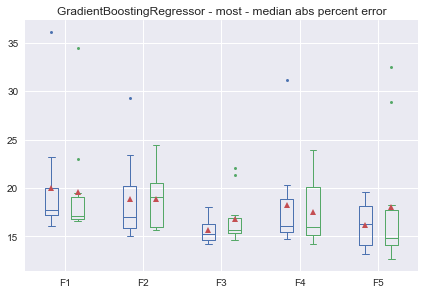

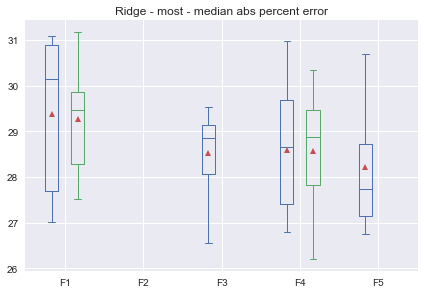

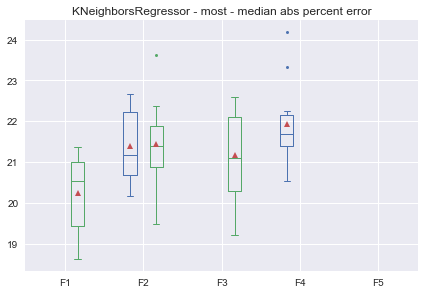

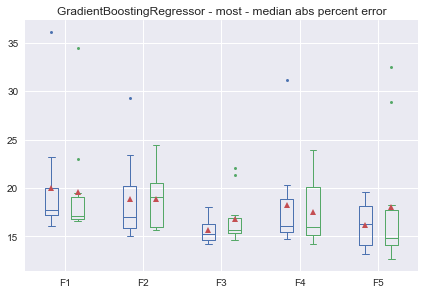

In [67]:
for met in res.metric.unique():
    for most in [True, False]:
        plt.show(make_base_plot(res, 'Ridge', most, met, 'manuscript/images')[0])
        plt.show(make_base_plot(res, 'KNeighborsRegressor', most, met, 'manuscript/images')[0])
        plt.show(make_base_plot(res, 'GradientBoostingRegressor', True, met, 'manuscript/images')[0])

## generation of tables

In [6]:
# for now we dont have nomost results, so we just copy the most ones
# so that we can preview how the tables will look like once they are complete
all_most = {'most', 'nomost'}
missing = all_most - set(res.most)
if missing:
    print('*** WARNING')
    print('replacing missing values in %s with fake measures' % missing)
    allres, missing = [], list(missing)[0]
    for row in res.values:
        allres.append(row)
        newrow = [x for x in row]
        newrow[3] = missing
        allres.append(newrow)
    allres = pd.DataFrame(allres, columns=res.columns)
else:
    allres = res

In [63]:
# rename stuff
renamed = allres[
    (allres.metric != 'explained_variance_score')
].replace({
    'most': {'most': 'Y', 'nomost': 'N'},
    'trend': {'trend': 'Y', 'notrend': 'N'},
    'metric': {
        'mean_squared_error': 'MSE',
        'median_squared_error': 'mSE',
        'mean_absolute_error': 'MAE',
        'median_absolute_error': 'mAE',
        'mean_abs_percent_error': 'MAPE',
        'median_abs_percent_error': 'mAPE',
        'r2_score': '$R^2$',
    },
    'features': {'f1': 'F1', 'f2': 'F2', 'f3': 'F3', 'f4': 'F4', 'f5': 'F5'}
}).rename(columns={
    'features': 'Features',
    'metric': 'Metric',
    'trend': 'Trend',
    'most': 'MOST'
})

most = 'both'

# one table for each estimator
for estimator in renamed.estimator.unique():
    if most == 'both':
        index = ['Metric', 'MOST', 'Trend']
        most_filter = True
    elif most == 'yes':
        index = ['Metric', 'Trend']
        most_filter = renamed.MOST == 'Y'
    elif most == 'no':
        index = ['Metric', 'Trend']
        most_filter = renamed.MOST == 'N'
    else:
        raise ValueError('most should be either yes, no, or both')
    
    est_res = renamed[
        (renamed.estimator == estimator) & most_filter
    ].pivot_table(
        columns='Features',
        values='value',
        index=index,
        aggfunc=lambda vals: '%.4f (%.4f)' % (vals.mean(), vals.std())
    )
    
    # useless and pollute output
    est_res.index.name = ''
    est_res.columns.name = ''
    
    # change order of metrics
    est_res = est_res.reindex([
        'MSE', '$R^2$', 'MAE', 'mAE', 'MAPE', 'mAPE'
    ], level=0)
    display(est_res)

    # use makecell to insert a line break between mean and std
    def format_col(text):
        return '\makecell[c]{%s}' % text.replace(' ', r'\\')

    latex = est_res.to_latex(
        escape=False,
        bold_rows=True,
        column_format='asd',
        multirow=True,
        formatters={
            'F1': format_col,
            'F2': format_col,
            'F3': format_col,
            'F4': format_col,
            'F5': format_col,
        }
    )

    # replace double clines with a single hline
    latex = re.sub(r'\\cline{.*?}\n\\cline{.*?}', '\hline', latex)
    
    # add tiny vertical space between cells
    # somewhat helps readability
    latex = '\centering\setcellgapes{0.15ex}\makegapedcells' + latex
    
    # since we used makecell to insert newlines inside each cell, we have
    # to double the vertical size of the multirows
    # also move metric name slightly upwards to make it aligned with center line
    # (move up by 1ex and down by 0.15ex to balance the padding)
    latex = re.sub(r'\\multirow{(\d+)}{\*}{(.*?)}', 
                   lambda m: r'\multirowcell{%d}[0.75ex][c]{%s}' % (2 * int(m[1]), m[2]),
                   latex)

    # use tabular* environment to make table fill the page width
    latex = latex.replace(
        r'\begin{tabular}{asd}',
        r'\begin{tabular*}{\textwidth}{c @{\extracolsep{\fill}} %sc|ccccc}' % (
            'c' if most == 'both' else ''
        )
    ).replace(r'\end{tabular}', r'\end{tabular*}')
    
    with open('manuscript/include/results_%s.tex' % estimator, 'w') as f:
        f.write(latex)

F1                   F2  \
Metric MOST Trend                                            
MSE    N    N                    None      0.4628 (0.0946)   
            Y         0.4689 (0.1408)      0.4408 (0.1169)   
       Y    N         0.2451 (0.0910)      0.2239 (0.0597)   
            Y         0.2513 (0.1097)      0.2183 (0.0680)   
$R^2$  N    N                    None      0.7919 (0.0523)   
            Y         0.7913 (0.0567)      0.8039 (0.0482)   
       Y    N         0.7025 (0.1154)      0.7303 (0.0661)   
            Y         0.6953 (0.1324)      0.7339 (0.0907)   
MAE    N    N                    None      0.4116 (0.0442)   
            Y         0.3994 (0.0618)      0.3959 (0.0536)   
       Y    N         0.3207 (0.0751)      0.3073 (0.0419)   
            Y         0.3264 (0.0829)      0.3062 (0.0630)   
mAE    N    N                    None      0.2393 (0.0362)   
            Y         0.2185 (0.0438)      0.2236 (0.0393)   
       Y    N         0.2142 (0.0767)      0.2036 (0.0321)   
            Y         0.2197 (0.0803)      0.2068 (0.0640)   
MAPE   N    N                    None  161.4667 (128.9329)   
            Y      118.5098 (60.7191)  134.4602 (106.1033)   
       Y    N      106.7338 (64.6517)   112.7565 (78.4367)   
            Y      111.1031 (89.4484)   108.6330 (71.4988)   
mAPE   N    N                    None     20.6016 (2.2858)   
            Y        19.3325 (2.9030)     19.4937 (2.4320)   
       Y    N        19.5859 (5.5771)     18.8398 (2.9050)   
            Y        20.0375 (6.0566)     18.8467 (4.4927)   

                                   F3                  F4                  F5  
Metric MOST Trend                                                              
MSE    N    N                    None                None                None  
            Y         0.4856 (0.1552)     0.3633 (0.0337)                None  
       Y    N         0.1995 (0.0385)     0.2127 (0.0623)     0.2369 (0.1526)  
            Y         0.1774 (0.0145)     0.2387 (0.1373)     0.1891 (0.0350)  
$R^2$  N    N                    None                None                None  
            Y         0.7807 (0.0812)     0.8374 (0.0095)                None  
       Y    N         0.7587 (0.0452)     0.7421 (0.0727)     0.7143 (0.1800)  
            Y         0.7851 (0.0146)     0.7171 (0.1391)     0.7711 (0.0402)  
MAE    N    N                    None                None                None  
            Y         0.4072 (0.0737)     0.3515 (0.0189)                None  
       Y    N         0.2809 (0.0360)     0.2915 (0.0478)     0.3012 (0.1012)  
            Y         0.2624 (0.0117)     0.3046 (0.0822)     0.2721 (0.0303)  
mAE    N    N                    None                None                None  
            Y         0.2281 (0.0589)     0.1887 (0.0186)                None  
       Y    N         0.1784 (0.0319)     0.1881 (0.0391)     0.1960 (0.0800)  
            Y         0.1636 (0.0084)     0.1963 (0.0571)     0.1731 (0.0251)  
MAPE   N    N                    None                None                None  
            Y      138.8603 (82.2512)  107.6871 (67.0553)                None  
       Y    N       97.3312 (70.3586)  111.2686 (69.5096)  116.2287 (85.8658)  
            Y       85.9461 (59.6627)  111.7788 (79.2053)   98.2588 (58.8734)  
mAPE   N    N                    None                None                None  
            Y        19.9467 (4.5721)    16.8228 (1.2081)                None  
       Y    N        16.8370 (2.6551)    17.5226 (3.3374)    18.0765 (6.8869)  
            Y        15.6185 (1.2942)    18.2306 (4.9151)    16.1767 (2.3647)

F1                   F2  \
Metric MOST Trend                                             
MSE    N    N          0.4480 (0.0453)      0.4799 (0.0405)   
            Y                     None      0.4800 (0.0298)   
       Y    N          0.2248 (0.0139)      0.2451 (0.0090)   
            Y          0.2259 (0.0230)      0.2454 (0.0183)   
$R^2$  N    N          0.8003 (0.0106)      0.7858 (0.0089)   
            Y                     None      0.7856 (0.0089)   
       Y    N          0.7284 (0.0073)      0.7019 (0.0083)   
            Y          0.7274 (0.0143)      0.7033 (0.0097)   
MAE    N    N          0.4073 (0.0209)      0.4272 (0.0208)   
            Y                     None      0.4271 (0.0121)   
       Y    N          0.3095 (0.0090)      0.3289 (0.0073)   
            Y          0.3104 (0.0131)      0.3286 (0.0110)   
mAE    N    N          0.2348 (0.0100)      0.2515 (0.0116)   
            Y                     None      0.2511 (0.0077)   
       Y    N          0.2036 (0.0077)      0.2224 (0.0066)   
            Y          0.2045 (0.0079)      0.2216 (0.0074)   
MAPE   N    N      149.6721 (128.3881)  162.0056 (104.5180)   
            Y                     None  176.1501 (164.4073)   
       Y    N       110.3192 (35.8902)   121.5696 (54.9411)   
            Y       110.7074 (36.5682)   122.2460 (44.1736)   
mAPE   N    N         20.2472 (0.9662)     21.4395 (1.0948)   
            Y                     None     21.3802 (0.8933)   
       Y    N         18.7901 (0.6521)     20.1785 (1.0779)   
            Y         18.8906 (0.9461)     20.1434 (0.9649)   

                                   F3                  F4                  F5  
Metric MOST Trend                                                              
MSE    N    N         0.4595 (0.0395)                None                None  
            Y                    None     0.4881 (0.0367)                None  
       Y    N         0.2397 (0.0153)     0.2520 (0.0128)     0.2522 (0.0226)  
            Y         0.2377 (0.0171)     0.2496 (0.0174)     0.2518 (0.0212)  
$R^2$  N    N         0.7950 (0.0072)                None                None  
            Y                    None     0.7826 (0.0080)                None  
       Y    N         0.7096 (0.0105)     0.6948 (0.0085)     0.6947 (0.0128)  
            Y         0.7128 (0.0113)     0.6983 (0.0108)     0.6952 (0.0133)  
MAE    N    N         0.4184 (0.0161)                None                None  
            Y                    None     0.4338 (0.0151)                None  
       Y    N         0.3247 (0.0108)     0.3354 (0.0103)     0.3378 (0.0145)  
            Y         0.3234 (0.0112)     0.3337 (0.0115)     0.3373 (0.0127)  
mAE    N    N         0.2489 (0.0088)                None                None  
            Y                    None     0.2588 (0.0073)                None  
       Y    N         0.2209 (0.0064)     0.2300 (0.0084)     0.2341 (0.0092)  
            Y         0.2199 (0.0068)     0.2289 (0.0086)     0.2335 (0.0076)  
MAPE   N    N      158.8155 (88.7095)                None                None  
            Y                    None  149.9039 (63.2003)                None  
       Y    N      122.5099 (47.6116)  130.4516 (33.2102)  119.1078 (29.1344)  
            Y      122.7503 (33.5558)  126.0556 (32.6292)  129.0683 (44.6798)  
mAPE   N    N        21.1605 (1.1530)                None                None  
            Y                    None    21.9414 (1.0811)                None  
       Y    N        20.0578 (0.5043)    20.7687 (1.0568)    21.0580 (0.9342)  
            Y        19.9896 (0.7828)    20.6616 (0.7322)    21.0165 (1.2088)

F1                  F2  \
Metric MOST Trend                                            
MSE    N    N          0.6308 (0.0478)                None   
            Y          0.6334 (0.0584)                None   
       Y    N          0.2734 (0.0156)     0.2748 (0.0283)   
            Y          0.2745 (0.0233)     0.2743 (0.0225)   
$R^2$  N    N          0.7178 (0.0213)                None   
            Y          0.7169 (0.0237)                None   
       Y    N          0.6694 (0.0174)     0.6667 (0.0263)   
            Y          0.6673 (0.0198)     0.6683 (0.0139)   
MAE    N    N          0.5291 (0.0179)                None   
            Y          0.5304 (0.0249)                None   
       Y    N          0.3571 (0.0092)     0.3581 (0.0161)   
            Y          0.3578 (0.0146)     0.3578 (0.0114)   
mAE    N    N          0.3646 (0.0110)                None   
            Y          0.3656 (0.0149)                None   
       Y    N          0.2529 (0.0060)     0.2538 (0.0083)   
            Y          0.2533 (0.0097)     0.2533 (0.0068)   
MAPE   N    N      262.8854 (258.3316)                None   
            Y      255.4641 (229.2480)                None   
       Y    N       137.3689 (73.0405)  138.2331 (65.4208)   
            Y       139.1836 (60.6234)  139.7290 (65.1058)   
mAPE   N    N         29.2682 (1.2482)                None   
            Y         29.3840 (1.6919)                None   
       Y    N         22.7373 (0.7710)    22.8955 (1.4606)   
            Y         22.8723 (1.6339)    22.8137 (0.8483)   

                                    F3                   F4  \
Metric MOST Trend                                             
MSE    N    N                     None      0.6265 (0.0588)   
            Y          0.6257 (0.0724)      0.6281 (0.0752)   
       Y    N          0.2730 (0.0244)      0.2724 (0.0162)   
            Y          0.2727 (0.0148)      0.2727 (0.0163)   
$R^2$  N    N                     None      0.7205 (0.0159)   
            Y          0.7215 (0.0166)      0.7197 (0.0267)   
       Y    N          0.6690 (0.0209)      0.6696 (0.0207)   
            Y          0.6689 (0.0160)      0.6691 (0.0199)   
MAE    N    N                     None      0.5232 (0.0197)   
            Y          0.5229 (0.0276)      0.5234 (0.0275)   
       Y    N          0.3563 (0.0154)      0.3559 (0.0103)   
            Y          0.3562 (0.0106)      0.3559 (0.0103)   
mAE    N    N                     None      0.3541 (0.0087)   
            Y          0.3545 (0.0122)      0.3541 (0.0114)   
       Y    N          0.2512 (0.0076)      0.2508 (0.0065)   
            Y          0.2512 (0.0084)      0.2508 (0.0067)   
MAPE   N    N                     None  278.4585 (368.1484)   
            Y      268.1731 (314.7478)  270.6003 (265.5856)   
       Y    N       140.7782 (70.9279)   140.1679 (77.4478)   
            Y      137.9176 (104.8360)   137.5744 (73.8904)   
mAPE   N    N                     None     28.5610 (1.3240)   
            Y         28.5289 (0.9219)     28.5987 (1.4217)   
       Y    N         22.6275 (0.9533)     22.5770 (1.0516)   
            Y         22.6234 (1.0045)     22.5605 (0.9555)   

                                    F5  
Metric MOST Trend                       
MSE    N    N                     None  
            Y          0.6164 (0.0789)  
       Y    N          0.2716 (0.0297)  
            Y          0.2703 (0.0213)  
$R^2$  N    N                     None  
            Y          0.7242 (0.0362)  
       Y    N          0.6719 (0.0228)  
            Y          0.6724 (0.0146)  
MAE    N    N                     None  
            Y          0.5184 (0.0312)  
       Y    N          0.3552 (0.0199)  
            Y          0.3543 (0.0123)  
mAE    N    N                     None  
            Y          0.3515 (0.0164)  
       Y    N          0.2504 (0.0134)  
            Y          0.2496 (0.0083)  
MAPE   N    N                     None  
     